In [67]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split

In [68]:
%matplotlib inline

In [69]:
DATA_PATH = './Data/'
IMAGE_PATH = '../RPN_Backbone_GZ2/Data/real_pngs/'

# using typical split of 70:20:10
SIZE_OF_VALIDATION_SET = 0.2
SIZE_OF_TEST_SET = 0.1

In [70]:
def print_sample_size(step, count):
    print('Total/Train/Validation/Test (step={}): {} {} {} {}'.format(
        step,
        int(count), 
        int(count*(1-SIZE_OF_VALIDATION_SET-SIZE_OF_TEST_SET)),
        int(count*SIZE_OF_VALIDATION_SET),
        int(count*SIZE_OF_TEST_SET)
    ))

In [71]:
df = pd.read_pickle(DATA_PATH + 'fullCatalogueWithFluxData.pkl')

In [47]:
df.head()

association          x1          x2          y1  \
zoo_id   clump_index                                                    
36718137 0                     34  257.611960  270.432472  166.130377   
         1                     38  110.566614  123.387126  227.192589   
         2                     51  131.395240  144.215751  187.996416   
         3                     58  126.491916  139.312428  263.842529   
36718138 0                      0  159.208100  175.806075  186.667868   

                              y2  x1_normed  x2_normed  y1_normed  y2_normed  \
zoo_id   clump_index                                                           
36718137 0            178.950889   0.644030   0.676081   0.415326   0.447377   
         1            240.013100   0.276417   0.308468   0.567981   0.600033   
         2            200.816927   0.328488   0.360539   0.469991   0.502042   
         3            276.663041   0.316230   0.348281   0.659606   0.691658   
36718138 0            203.265843   0.398020   0.439515   0.466670   0.508165   

                      mean_tool  ... clump_flux_ratio_r_over_g  \
zoo_id   clump_index             ...                             
36718137 0             0.166667  ...                  2.706576   
         1             0.000000  ...                  3.496440   
         2             0.166667  ...                  3.436437   
         3             0.176471  ...                  1.989409   
36718138 0             0.250000  ...                  2.076021   

                     clump_flux_ratio_r_over_i  clump_flux_ratio_i_over_g  \
zoo_id   clump_index                                                        
36718137 0                            0.987149                   2.741810   
         1                            1.012472                   3.453371   
         2                            0.660494                   5.202830   
         3                            0.693173                   2.870002   
36718138 0                            0.789291                   2.630234   

                      clump_flux_ratio_i_over_r  \
zoo_id   clump_index                              
36718137 0                             1.013018   
         1                             0.987682   
         2                             1.514019   
         3                             1.442641   
36718138 0                             1.266960   

                      clump_flux_ratio_g_over_r_lscale  \
zoo_id   clump_index                                     
36718137 0                                    0.617544   
         1                                    0.478037   
         2                                    0.486384   
         3                                    0.840163   
36718138 0                                    0.805112   

                      clump_flux_ratio_g_over_i_lscale  \
zoo_id   clump_index                                     
36718137 0                                    0.947237   
         1                                    0.752060   
         2                                    0.499179   
         3                                    0.904927   
36718138 0                                    0.987419   

                      clump_flux_ratio_r_over_g_lscale  \
zoo_id   clump_index                                     
36718137 0                                    1.619319   
         1                                    2.091887   
         2                                    2.055988   
         3                                    1.190245   
36718138 0                                    1.242063   

                     clump_flux_ratio_r_over_i_lscale  \
zoo_id   clump_index                                    
36718137 0                                   1.533878   
         1                                   1.573225   
         2                                   1.026306   
         3                                   1.077085   
36718138 0               

In [ ]:
list(df.columns)

<AxesSubplot: xlabel='value', ylabel='variable'>

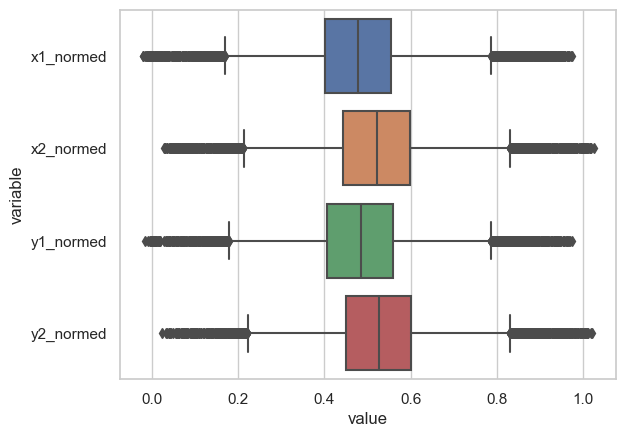

In [7]:
stat_df = pd.melt(
    df.reset_index(),
    id_vars=['zoo_id', 'clump_index'], 
    value_vars=['x1_normed', 'x2_normed', 'y1_normed', 'y2_normed']
)
sns.boxplot(data=stat_df, x='value', y='variable')

<AxesSubplot: xlabel='x1', ylabel='y1'>

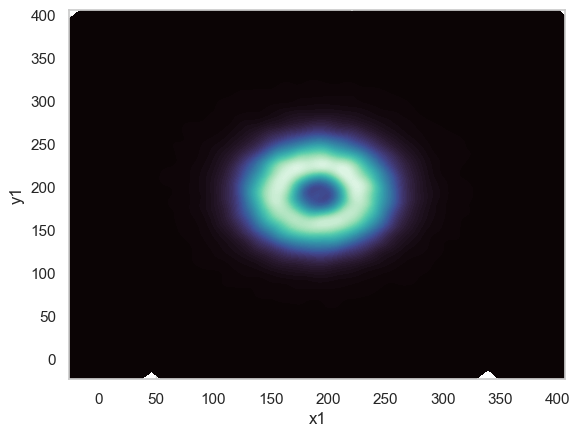

In [8]:
sns.kdeplot(
    data=df, 
    x='x1', 
    y='y1', 
    fill=True,
    thresh=0,
    levels=100, 
    cmap="mako",
    legend=True,
)

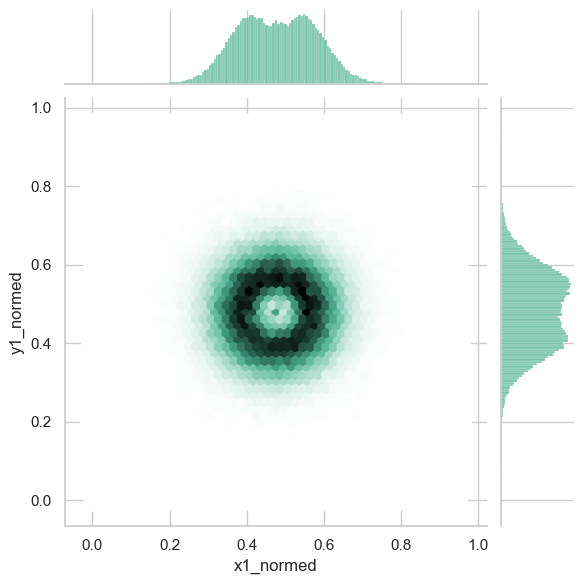

In [9]:
sns.jointplot(
    x=df['x1_normed'],
    y=df['y1_normed'],
    kind='hex', 
    color='#4CB391'
)

In [10]:
x_bounds = np.rint(np.array([df['x1'].quantile(0.01), df['x2'].quantile(0.99)]))
y_bounds = np.rint(np.array([df['y1'].quantile(0.01), df['y2'].quantile(0.99)]))

print('X-bounds: {}\nY-bounds: {}'.format(x_bounds, y_bounds))

X-bounds: [100. 301.]
Y-bounds: [104. 302.]


In [72]:
CUTOUT = (100, 100, 300, 300)
CUTOUT_ARRAY = np.array([100, 300, 100, 300])

In [49]:
print_sample_size('Total', df['local_id'].nunique())

Total/Train/Validation/Test (step=Total): 20683 14478 4136 2068


In [73]:
df.reset_index(inplace=True)

# Filter out any bulge markings that snuck through
df['is_central'] = (
    np.abs(0.5*(df['x2_normed'] + df['x1_normed']) - 0.5) < 0.02
    ) & (
    np.abs(0.5*(df['y2_normed'] + df['y1_normed']) - 0.5) < 0.02
    )

# and reduce to only samples with objects
df = df[(~df['is_central'] | df['empty'])]

In [51]:
print_sample_size('no bulge markings', df['local_id'].nunique())

Total/Train/Validation/Test (step=no bulge markings): 20646 14452 4129 2064


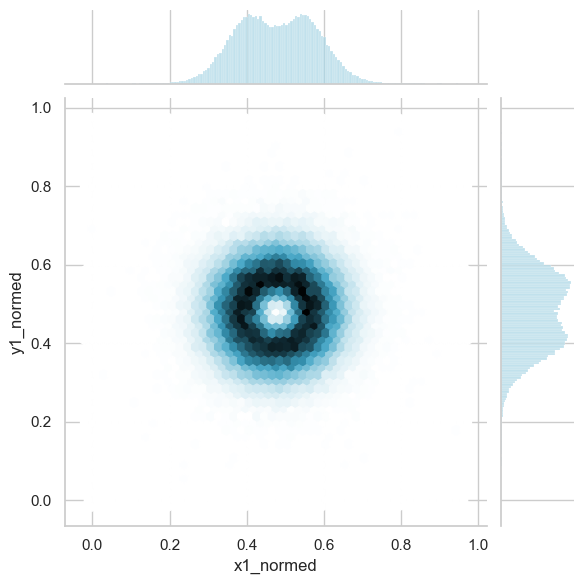

In [52]:
sns.jointplot(
    x=df['x1_normed'],
    y=df['y1_normed'],
    kind='hex', 
    color='lightblue'
)

In [74]:
cutout = CUTOUT_ARRAY
cutout_normed = CUTOUT_ARRAY/400

# Convert x/y normed
pad = 0.05
df['pad_selector'] = (
    df['x1_normed'] > cutout_normed[0] + pad
    ) & (
    df['x2_normed'] < cutout_normed[1] - pad
    ) & (
    df['y1_normed'] > cutout_normed[2] + pad
    ) & (
    df['y2_normed'] < cutout_normed[3] - pad
    )

df = df[(df['pad_selector'] | df['empty'])]

In [54]:
print_sample_size('no clumps at rim', df['local_id'].nunique())

Total/Train/Validation/Test (step=no clumps at rim): 19371 13559 3874 1937


In [75]:
# convert to cutout size
def convert_x_normed(x_normed):
    x_normed = (x_normed - cutout_normed[0]) / (cutout_normed[1] - cutout_normed[0])
    return x_normed

def convert_y_normed(y_normed):
    y_normed = (y_normed - cutout_normed[2]) / (cutout_normed[3] - cutout_normed[2])
    return y_normed

df['x1_normed'] = df.apply(lambda x: convert_x_normed(x['x1_normed']), axis=1)
df['x2_normed'] = df.apply(lambda x: convert_x_normed(x['x2_normed']), axis=1)
df['y1_normed'] = df.apply(lambda y: convert_y_normed(y['y1_normed']), axis=1)
df['y2_normed'] = df.apply(lambda y: convert_y_normed(y['y2_normed']), axis=1)

df['x1'] = df['x1_normed'] * (cutout[1] - cutout[0])
df['x2'] = df['x2_normed'] * (cutout[1] - cutout[0])
df['y1'] = df['y1_normed'] * (cutout[3] - cutout[2])
df['y2'] = df['y2_normed'] * (cutout[3] - cutout[2])

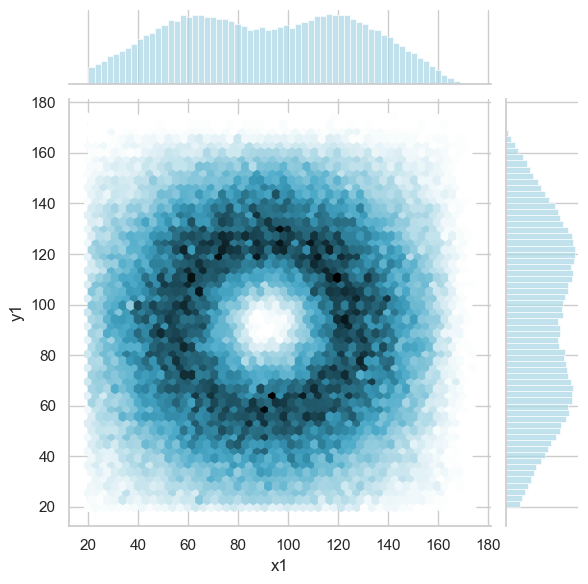

In [80]:
sns.jointplot(
    x=df['x1'],
    y=df['y1'],
    kind='hex', 
    color='lightblue'
).figure.savefig("hex_plot.png")

In [81]:
# Check, if image exists
df['filename'] = IMAGE_PATH + df['local_id'].astype('Int64').apply(str) + '.png'
df['file_exists'] = (df['filename']).apply(os.path.exists)
df = df[df['file_exists']]

In [82]:
print_sample_size('with file', df['local_id'].nunique())

Total/Train/Validation/Test (step=with file): 18772 13140 3754 1877


In [83]:
# labels
# 0 - background
# 1 - Clump 
# 2 - Odd Clump
# 3 - Improbable Clump
# 4 - Odd Improbable Clump
df['is_odd'] = np.where(df['mean_tool'] > 0.5, True, False)
df['is_improbable'] = np.where(df['false_pos_prob_x'] > 0.7, True, False)

df['label'] = np.select(
    [
        (~df['empty']) & (~df['is_odd']) & (~df['is_improbable']),
        (~df['empty']) & (df['is_odd']) & (~df['is_improbable']),
        (~df['empty']) & (~df['is_odd']) & (df['is_improbable']),
        (~df['empty']) & (df['is_odd']) & (df['is_improbable']),
    ], 
    [
        1,
        2,
        2, #3,
        2, #4,
    ],
    default = None
)

df['label_text'] = np.select(
    [
        (~df['empty']) & (~df['is_odd']) & (~df['is_improbable']),
        (~df['empty']) & (df['is_odd']) & (~df['is_improbable']),
        (~df['empty']) & (~df['is_odd']) & (df['is_improbable']),
        (~df['empty']) & (df['is_odd']) & (df['is_improbable']),
    ], 
    [
        b'clump',
        b'clump, odd',
        b'clump, odd', # b'clump, improbable',
        b'clump, odd', # b'clump, odd and improbable',
    ],
    default = ''
)

In [66]:
df[df['zoo_id']==36718137]['local_id'].astype(int)

0    248728316855
2    248728316855
3    248728316855
Name: local_id, dtype: int64

In [63]:
# saving full set
df.to_pickle('clump_scout_full_set.pkl')
df.to_csv('clump_scout_full_set.csv')

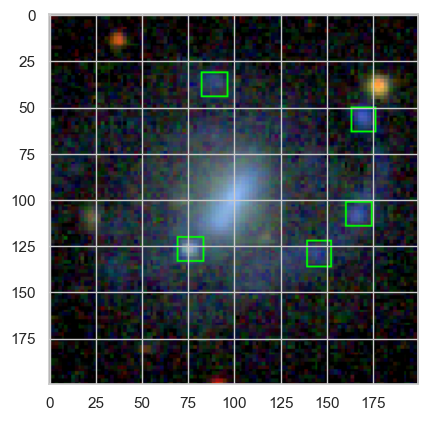

In [62]:
image_id = 36735225

df_plot = df[df['zoo_id'] == image_id]

image = cv2.imread(df_plot['filename'].iloc[0])[cutout[0]:cutout[1],cutout[2]:cutout[3]]
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # the image is in RGB, convert to BGR for cv2 annotations

for idx, data in df_plot.iterrows():
    cv2.rectangle(
        image,
        (int(data['x1']), int(data['y1'])),
        (int(data['x2']), int(data['y2'])),
        (0, 255, 0),
        1
    )
plt.imshow(image)

## Create run-sets

In [24]:
df.head()

,zoo_id,clump_index,association,x1,x2,y1,y2,x1_normed,x2_normed,y1_normed,...,clump_flux_ratio_i_over_g_lscale,clump_flux_ratio_i_over_r_lscale,is_central,pad_selector,filename,file_exists,is_odd,is_improbable,label,label_text
0,36718137,0,34,157.611960,170.432472,66.130377,78.950889,0.788060,0.852162,0.330652,...,1.055702,0.651942,False,True,../RPN_Backbone_GZ2/Data/real_pngs/24872831685...,True,False,False,1,clump
2,36718137,2,51,31.395240,44.215751,87.996416,100.816927,0.156976,0.221079,0.439982,...,2.003290,0.974369,False,True,../RPN_Backbone_GZ2/Data/real_pngs/24872831685...,True,False,False,1,clump
3,36718137,3,58,26.491916,39.312428,163.842529,176.663041,0.132460,0.196562,0.819213,...,1.105061,0.928432,False,True,../RPN_Backbone_GZ2/Data/real_pngs/24872831685...,True,False,False,1,clump
4,36718138,0,0,59.208100,75.806075,86.667868,103.265843,0.296041,0.379030,0.433339,...,1.012741,0.815371,False,True,../RPN_Backbone_GZ2/Data/real_pngs/36665868979...,True,False,True,2,"clump, odd"
5,36718138,1,7,135.144270,151.742245,104.555084,121.153058,0.675721,0.758711,0.522775,...,0.773867,0.755368,False,True,../RPN_Backbone_GZ2/Data/real_pngs/36665868979...,True,False,False,1,clump


In [84]:
# initialise dictionary with sizes for each sample used for a run
run_dict = {}
counter = 0

for i in range (200, 5000, 200):
    counter += 1
    run_dict[counter] = i

for i in range (5000, 12500, 500):
    counter += 1
    run_dict[counter] = i

# add last entry for full run
run_dict[counter+1] = df['local_id'].nunique()

In [85]:
df_full_set = (df
    .reset_index()
    .assign(clumps=0, odd_clumps=0)
    .assign(clumps=lambda df_: df_.clumps.where(df_.label==2, 1))
    .assign(odd_clumps=lambda df_: df_.odd_clumps.where(df_.label==1, 1))
    .groupby(['zoo_id'])
    .agg({
            'clumps': 'sum',
            'odd_clumps': 'sum'
    })
    .reset_index()
    .assign(stratification_class='more clumps')
    .assign(stratification_class=lambda df_: df_.stratification_class.where(df_.clumps >= df_.odd_clumps, 'more odd clumps'))
)


In [86]:
df_full_set.shape

(18772, 4)

In [28]:
print(df_full_set['clumps'].sum(), df_full_set['odd_clumps'].sum())

29619 10126


In [87]:
df_runs = df_full_set.iloc[:0].copy()
full_size = df['local_id'].nunique()

for run, size in run_dict.items():
    if size != full_size:
        _, sample = train_test_split(
            df_full_set, 
            test_size=size, 
            stratify=df_full_set[['stratification_class']],
        )
    else:
        sample = df_full_set
    
    train_set, hidden_set = train_test_split(
        sample, 
        test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET,
        stratify=sample[['stratification_class']],
        random_state=75,
    )
    val_set, test_set = train_test_split(
        hidden_set, 
        test_size=SIZE_OF_TEST_SET / (SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET), 
        stratify=hidden_set[['stratification_class']],
        random_state=75,
    )
    
    train_set['run'] = run
    train_set['group'] = 'Training'
    val_set['run'] = run
    val_set['group'] = 'Validation'
    test_set['run'] = run
    test_set['group'] = 'Testing'

    df_runs = pd.concat([df_runs, train_set, val_set, test_set])

df_runs['run'] = df_runs['run'].astype(int)
df_runs['stratification_class'] = df_runs['stratification_class'].astype('category')
df_runs['group'] = df_runs['group'].astype('category')

In [88]:
df_control = (df_runs
    .groupby(['run', 'group'])
    .agg({
        'zoo_id': ['nunique', 'count'],
        'clumps': 'sum',
        'odd_clumps': 'sum'
    })
    #.assign(clump_ratio=df_control.xs('clumps', axis=1)/df_control.xs('odd_clumps', axis=1).astype(float))
)
df_control.columns = ['_'.join(col) for col in df_control.columns]
df_control = df_control.reset_index()
df_control['clump_ratio'] = df_control['clumps_sum'] / df_control['odd_clumps_sum'].astype(float)

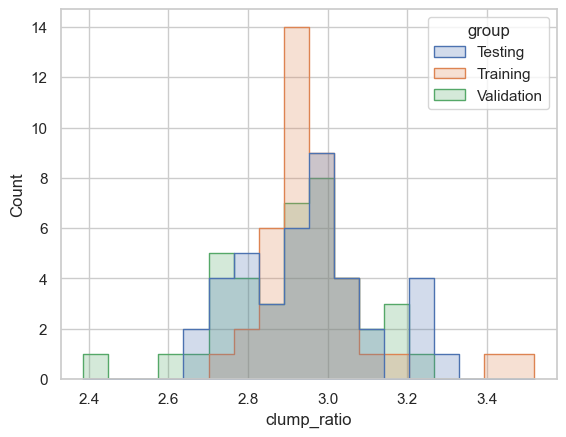

In [89]:
sns.histplot(
    data=df_control, 
    x='clump_ratio',
    hue='group',
    element='step',
).figure.savefig("clump_ratio.png")

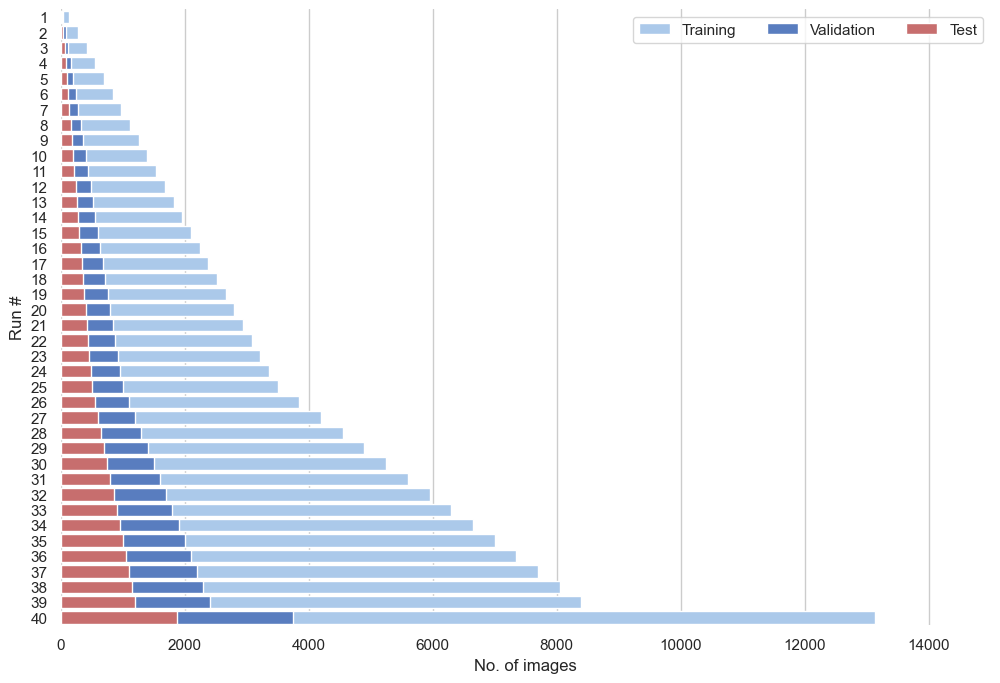

In [90]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Plot training
sns.set_color_codes("pastel")
sns.barplot(
    data=df_control[df_control['group'] == 'Training'],
    x='zoo_id_count',
    y='run',
    orient='h',
    label='Training', 
    color='b'
)
# Plot validation
sns.set_color_codes("muted")
sns.barplot(
    data=df_control[df_control['group'] == 'Validation'],
    x='zoo_id_count',
    y='run',
    orient='h',
    label='Validation', 
    color='b'
)
# Plot test
sns.set_color_codes("muted")
sns.barplot(
    data=df_control[df_control['group'] == 'Testing'],
    x='zoo_id_count',
    y='run',
    orient='h',
    label='Test', 
    color='r'
)

# Add a legend and informative axis label
ax.legend(ncol=3, loc='upper right', frameon=True)
ax.set(
    xlim=(0, 15000), 
    ylabel='Run #',
    xlabel='No. of images'
)
sns.despine(left=True, bottom=True)

f.figure.savefig("runs.png")

In [33]:
# saving run dataframe
df_runs.to_pickle('image_ids_for_runs.pkl')
df_runs.to_csv('image_ids_for_runs.csv')